In this notebook, we walk through an example of how to run TRICERATOPS to statistically validate a transiting planet observed by TESS.

In [1]:
import numpy as np
import pandas as pd
import time
from lightkurve import TessLightCurve
import matplotlib.pyplot as plt
%matplotlib inline

import triceratops.triceratops as tr

/Users/stevengiacalone/opt/anaconda3/envs/test_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/stevengiacalone/opt/anaconda3/envs/test_env/lib/python3.8/site-packages/pytools/persistent_dict.py:59: UserWarning: pytools.persistent_dict: unable to import 'siphash24.siphash13', falling back to hashlib.sha256
  warn("pytools.persistent_dict: unable to import 'siphash24.siphash13', "


### Step 1: Import and format data.

Before we even initialize TRICERATOPS, let's load in our data. In this example, we'll reproduce the validation of TOI-1228 b (a.k.a. HD 56414 b), a warm Neptune orbiting an A-type star (see [Giacalone et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...935L..10G/abstract) for more info.) We're going to utilize two files for this analysis:

- TOI1228_folded_lightcurve.csv - the *phase-folded* TESS light curve of the host star
- a SOAR/HRCam speckle contrast curve of the host star (PI: Tokovinin)

Let's start with the TESS data.

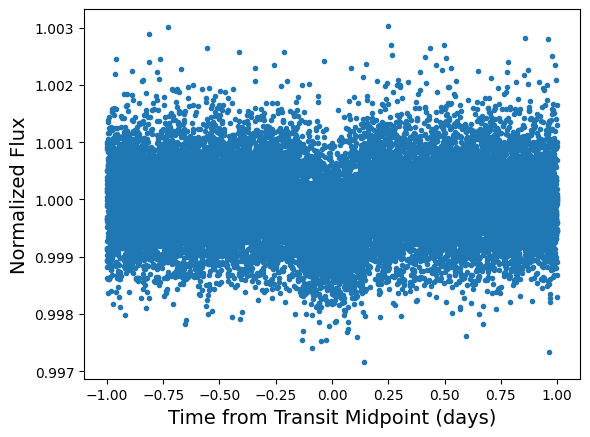

In [10]:
lc = pd.read_csv("TOI1228_folded_lightcurve.csv")
t = lc.x_fold.values
y = lc.y.values + 1

plt.scatter(t, y, marker='.')
plt.xlabel("Time from Transit Midpoint (days)", fontsize=14)
plt.ylabel("Normalized Flux", fontsize=14)
plt.show()

**IMPORTANT :** Note the normalization the units here. The flux data should be normalized to a baseline of 1 and the time data should be in units of days. 

We can see the transit, but there is *way* too much data to input into TRICERATOPS (the code would crash). To remedy this, we're going to do two things: (1) trim the data so that it only extends to about +/- 1 transit duration from transit ingress/egress, and then (2) bin the data down to about 200 points.

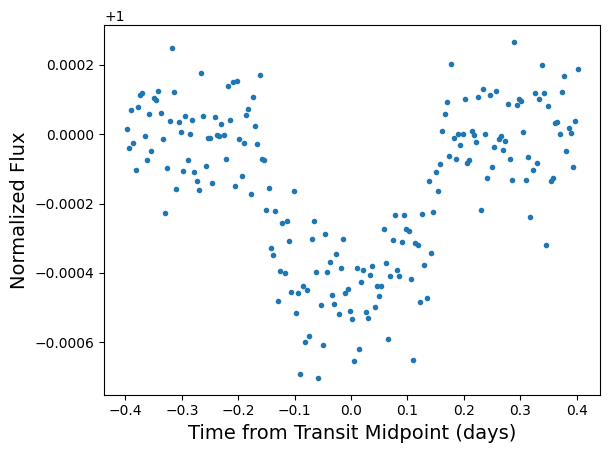

In [29]:
transit_mask = (np.abs(t) < 0.4)
lc_binned = TessLightCurve(time=t[transit_mask], flux=y[transit_mask]).bin(time_bin_size=2*np.max(t[transit_mask])/200)
t_binned = lc_binned.time.value
y_binned = lc_binned.flux.value

plt.scatter(t_binned, y_binned, marker='.')
plt.xlabel("Time from Transit Midpoint (days)", fontsize=14)
plt.ylabel("Normalized Flux", fontsize=14)
plt.show()

Looks good! Now let's take a look at the speckle contrast curve.

The contrast curve file should be comma-separated and should contain two columns: (1) the angular separation of the contrast curve (in arcseconds), and (2) the contrast (or $\Delta$ Mag). There should be no header (just the data). Here's what it should look like, when loaded in with pandas:

In [34]:
cc = pd.read_csv("TOI1228_cc.tbl", header=None)
cc

,0,1
0,0.00,0.0
1,0.07,1.0
2,0.20,4.5
3,0.25,5.5
4,2.20,6.5


### Step 2: Initialize TRICERATOPS.

Okay, now let's initilize the code. All we need for the initialization is the TIC ID of the star and the sectors in which star has been observed. This particular star is in the southern CVZ and has been observed for >30 sectors, so to speed things up we'll just use the first sector. The other optional arguments are listed, to give you a taste of the available options.

In [35]:
ID = 300038935
sectors = np.array([1])
target = tr.target(ID=ID,                       # TIC ID (int)
                   sectors=sectors,             # TESS sectors (numpy array)
                   search_radius=10,            # number of pixels to search from target star (int)
                   mission="TESS",              # which mission you are using data from ("TESS" or "Kepler" currently supported)
                   lightkurve_cache_dir=None,   # directory containing lightkurve data products (str)
                   trilegal_fname=None,         # name of TRILEGAL query results (str, generated after first run)
                   ra=None,                     # ra if target ID is unknown (float, degrees)
                   dec=None)                    # dec if target ID is unknown (float, degrees)
                  

Getting TessCut for sector 1


### Step 3: Get the SPOC aperture for the target and visualize (optional)

Now that we've gotten started, let's take a look at the field of stars and the photometric aperture. This gives us a good idea of how much non-target-star light is contaminating the aperture used to extract the light curve.

We can use the new get_SPOC_apertures method to retrieve the SPOC aperture used for the target in any given sector. Note that this will return nothing if there the target was not processed by SPOC with non-FFI data.

In [42]:
aps = target.get_spoc_apertures()
print(aps)

[array([[ 997, 1711],
       [ 998, 1711],
       [ 999, 1711],
       [1000, 1711],
       [ 996, 1712],
       [ 997, 1712],
       [ 998, 1712],
       [ 999, 1712],
       [1000, 1712],
       [1001, 1712],
       [ 996, 1713],
       [ 997, 1713],
       [ 998, 1713],
       [ 999, 1713],
       [1000, 1713],
       [1001, 1713],
       [ 997, 1714],
       [ 998, 1714],
       [ 999, 1714],
       [1000, 1714],
       [1001, 1714],
       [ 998, 1715],
       [ 999, 1715],
       [1000, 1715]])]


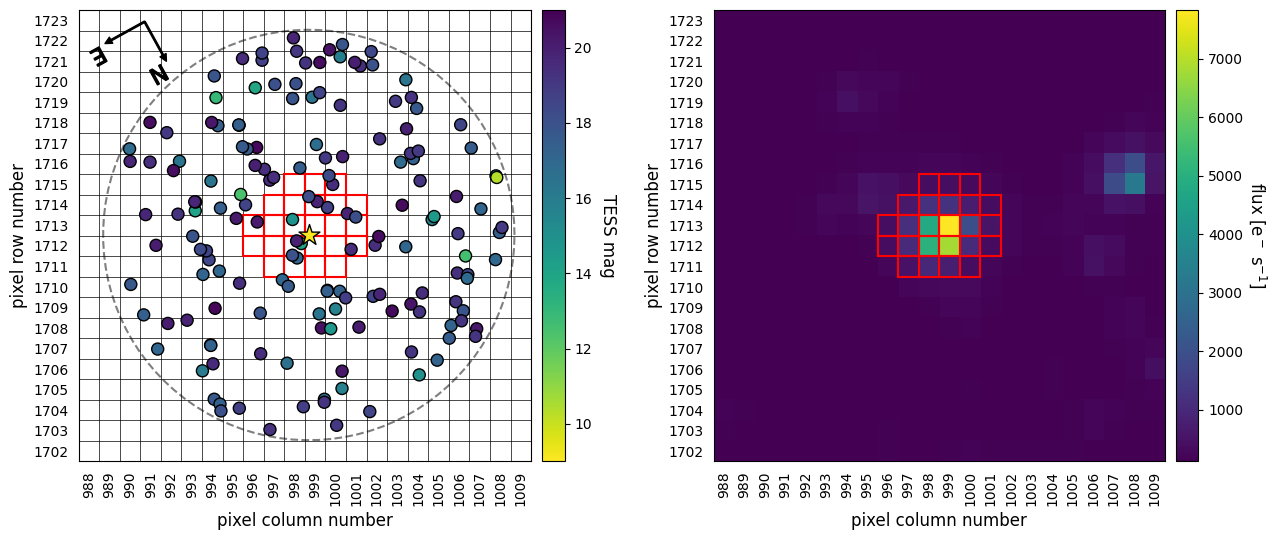

In [44]:
target.plot_field(sector=sectors[0],     # sector to plot (int)
                  ap_pixels=aps[0],      # which aperture to plot (numpy array, optional)
                  ap_color="red",        # color to make aperture (str, red is default)
                  save=False,            # whether or not to save the figure (bool)
                  fname=None)            # name of file, if saved (str)
                 

We can also print a dataframe containing the properties and positions of all nearby stars (ordered according to distance from the target.

In [45]:
target.stars

,ID,Tmag,Jmag,Hmag,Kmag,ra,dec,mass,rad,Teff,plx,sep (arcsec),PA (E of N)
0,300038935,9.0963,8.887,8.854,8.823,107.843696,-68.833491,2.13000,1.796260,8557.0,3.644910,0.000,0.000
1,300038933,14.2544,13.082,12.418,12.225,107.852043,-68.832404,0.58456,0.595692,3922.0,3.706540,11.535,70.169
2,764971651,19.8793,NaN,NaN,NaN,107.854143,-68.833701,NaN,NaN,NaN,-0.335280,13.601,93.195
3,300038940,14.8737,13.832,13.213,13.137,107.848770,-68.839563,0.75000,0.641739,4690.0,1.934550,22.832,163.211
4,300038932,17.0169,16.356,15.803,15.684,107.860272,-68.829404,0.96000,0.580447,5484.0,0.565248,26.094,55.680
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,764971826,19.1761,NaN,NaN,NaN,107.770256,-68.785450,NaN,NaN,5252.0,0.689064,197.595,331.042
157,300087657,18.0168,16.728,15.811,15.694,107.969395,-68.801970,0.62000,1.205220,3985.0,0.062828,199.030,55.298
158,300087609,16.8030,16.244,15.765,15.422,107.931628,-68.879448,NaN,NaN,NaN,NaN,201.022,145.429
159,764971579,19.8112,NaN,NaN,NaN,107.779008,-68.884382,NaN,NaN,NaN,0.130138,201.542,204.598


### Step 4: Calculate the flux contribution from each star near the target.

In this step, we calculate how much flux each nearby star contributes to the TESS light curve. We need to know this information to properly model transiting planets and eclipsing binaries around each of the known sources near the target.

In [46]:
target.calc_depths(tdepth=0.000407,           # transit depth of the planet candidate in the TESS data (float)
                   all_ap_pixels=aps)         # apertures to use for calculation (list of numpy arrays)

You'll notice that there was a warning when we ran that. The warning is due to a nearby star that is capable of causing the observed transit having incomplete stellar parameters in the TIC. By default, the code will assume Solar parameters for those that are missing. We'll go with that for now, but you can also manually enter stellar parameters, if you prefer.

Returning the stars dataframe again reveals the flux ratio contributed by each nearby star and the corresponding *true* transit depth (i.e., the depth the event would have if there we no contamination). Stars with a tdepth of zero are too faint to cause the observed signal, so we can ignore those.

In [48]:
target.stars[target.stars.tdepth > 0]

,ID,Tmag,Jmag,Hmag,Kmag,ra,dec,mass,rad,Teff,plx,sep (arcsec),PA (E of N),fluxratio,tdepth
0,300038935,9.0963,8.887,8.854,8.823,107.843696,-68.833491,2.13000,1.796260,8557.0,3.644910,0.000,0.000,0.979954,0.000415
1,300038933,14.2544,13.082,12.418,12.225,107.852043,-68.832404,0.58456,0.595692,3922.0,3.706540,11.535,70.169,0.008361,0.048680
3,300038940,14.8737,13.832,13.213,13.137,107.848770,-68.839563,0.75000,0.641739,4690.0,1.934550,22.832,163.211,0.004675,0.087064
4,300038932,17.0169,16.356,15.803,15.684,107.860272,-68.829404,0.96000,0.580447,5484.0,0.565248,26.094,55.680,0.000589,0.690429
16,300038925,14.2296,13.282,12.879,12.705,107.852177,-68.817218,0.88000,0.863853,5192.0,1.569100,59.611,10.666,0.001471,0.276603
29,300038947,12.4406,11.452,10.912,10.810,107.874142,-68.852895,NaN,3.224470,4986.0,1.040730,80.277,150.491,0.003010,0.135210


### Step 5: Calculate the false positive probability.

Now we're ready to run the probability calculation. Let's do that below.

In [53]:
target.calc_probs(time=t_binned,                               # binned time data
                  flux_0=y_binned,                             # binned flux data
                  flux_err_0=np.std(y_binned[:50]),            # standard deviation of (out-of-transit) flux data
                  P_orb=29.04992,                              # best-fit orbital period of planet candidate
                  contrast_curve_file="TOI1228_cc.tbl",        # contrast curve file to use (str)
                  filt="TESS",                                 # passband of contrast curve ("TESS", "J", "H", or "K")
                  N=int(1e6),                                  # number of instances to simulate for each scenario (int, usually fine to leave alone)
                  parallel=True,                               # whether or not to use parallel processing (bool)
                  drop_scenario=[],                            # scenarios to ignore (e.g., "EB")
                  verbose=1,                                   # whether or not to print updates (0 or 1)
                  flatpriors=False,                            # whether or not to assume flat planet priors (bool)
                  exptime=0.00139,                             # exposure time of TESS data (float, in days)
                  nsamples=20,                                 # number of samples to use for supersampling (int, leave alone)
                  molusc_file="TOI1228_molusc_kept.csv")       # path to molusc file (str, optional)

Calculating TP scenario probabilitiey for 300038935.
Calculating EB and EBx2P scenario probabilities for 300038935.
Calculating PTP scenario probability for 300038935.
Calculating PEB and PEBx2P scenario probabilities for 300038935.
Calculating STP scenario probability for 300038935.
Calculating SEB and SEBx2P scenario probabilities for 300038935.
Calculating DTP scenario probability for 300038935.
Calculating DEB and DEBx2P scenario probabilities for 300038935.
Calculating BTP scenario probability for 300038935.
Calculating BEB and BEBx2P scenario probabilities for 300038935.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 300038933.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 300038940.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 300038932.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 300038925.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 300038947.


The "molusc_file" argument is a csv containing the results of Mackenna Wood's [molusc](https://github.com/woodml/MOLUSC) code. This code generates a realistic prior distribution of physically associated binary stars given constraints from follow-up (e.g., imageing, RVs) and archival (e.g., Gaia) data. It is much more sophisticated than the default prodecure used by TRICERATOPS. While it is optional, I recommend people use it.

### Step 6: Analyze the results.

The code calculates two numbers: (1) the false positive probability (the overall probability that the planet candidate is an astrophysical false positive), and (2) the nearby false positive probability (the probability that the signal comes from a different, known, nearby star). Let's print them to see how we did. In general, a planet can be validated if FFF < 1% and NFPP < 0.1%.

In [55]:
print("FPP =", target.FPP)
print("NFPP =", target.NFPP)

FPP = 4.0886843621912305e-07
NFPP = 2.3616675104025124e-07


Looks good! We can also print a table containing the relative probability of each scenario.

In [56]:
target.probs

,ID,scenario,M_s,R_s,P_orb,inc,b,ecc,w,R_p,M_EB,R_EB,prob
0,300038935,TP,2.130000,1.796260,29.04992,88.855427,0.483130,0.256514,156.993280,4.120417,0.000000,0.000000,6.369984e-01
1,300038935,EB,2.130000,1.796260,29.04992,86.528950,1.874672,0.135202,62.493660,0.000000,1.931239,1.796260,7.656893e-203
2,300038935,EBx2P,2.130000,1.796260,58.09984,88.499390,0.339002,0.836410,157.588780,0.000000,2.098615,1.796260,6.703211e-76
3,300038935,PTP,2.130000,1.796260,29.04992,89.840529,0.091749,0.174320,291.559946,3.962407,0.000000,0.000000,1.462648e-01
4,300038935,PEB,2.130000,1.796260,29.04992,86.674836,1.982027,0.013326,38.118084,0.000000,1.640497,1.790837,3.887469e-207
5,300038935,PEBx2P,2.130000,1.796260,58.09984,87.969156,1.995787,0.015123,13.446300,0.000000,2.031691,1.796260,1.055615e-179
6,300038935,STP,1.344670,1.494339,29.04992,89.627271,0.186055,0.045966,147.260456,6.890003,0.000000,0.000000,5.635371e-08
7,300038935,SEB,0.907606,0.947389,29.04992,89.407698,0.101152,0.811445,144.886641,0.000000,0.095463,0.113374,2.598839e-36
8,300038935,SEBx2P,0.471611,0.470809,58.09984,89.667172,0.381270,0.639552,163.603241,0.000000,0.463413,0.462115,3.134851e-16
9,300038935,DTP,2.130000,1.796260,29.04992,88.915844,0.477434,0.204002,156.324831,4.028124,0.000000,0.000000,2.167364e-01


Laslty, we can plot the maximum-likelihood transit model for each scenario to see how these probabilities translate to the models.

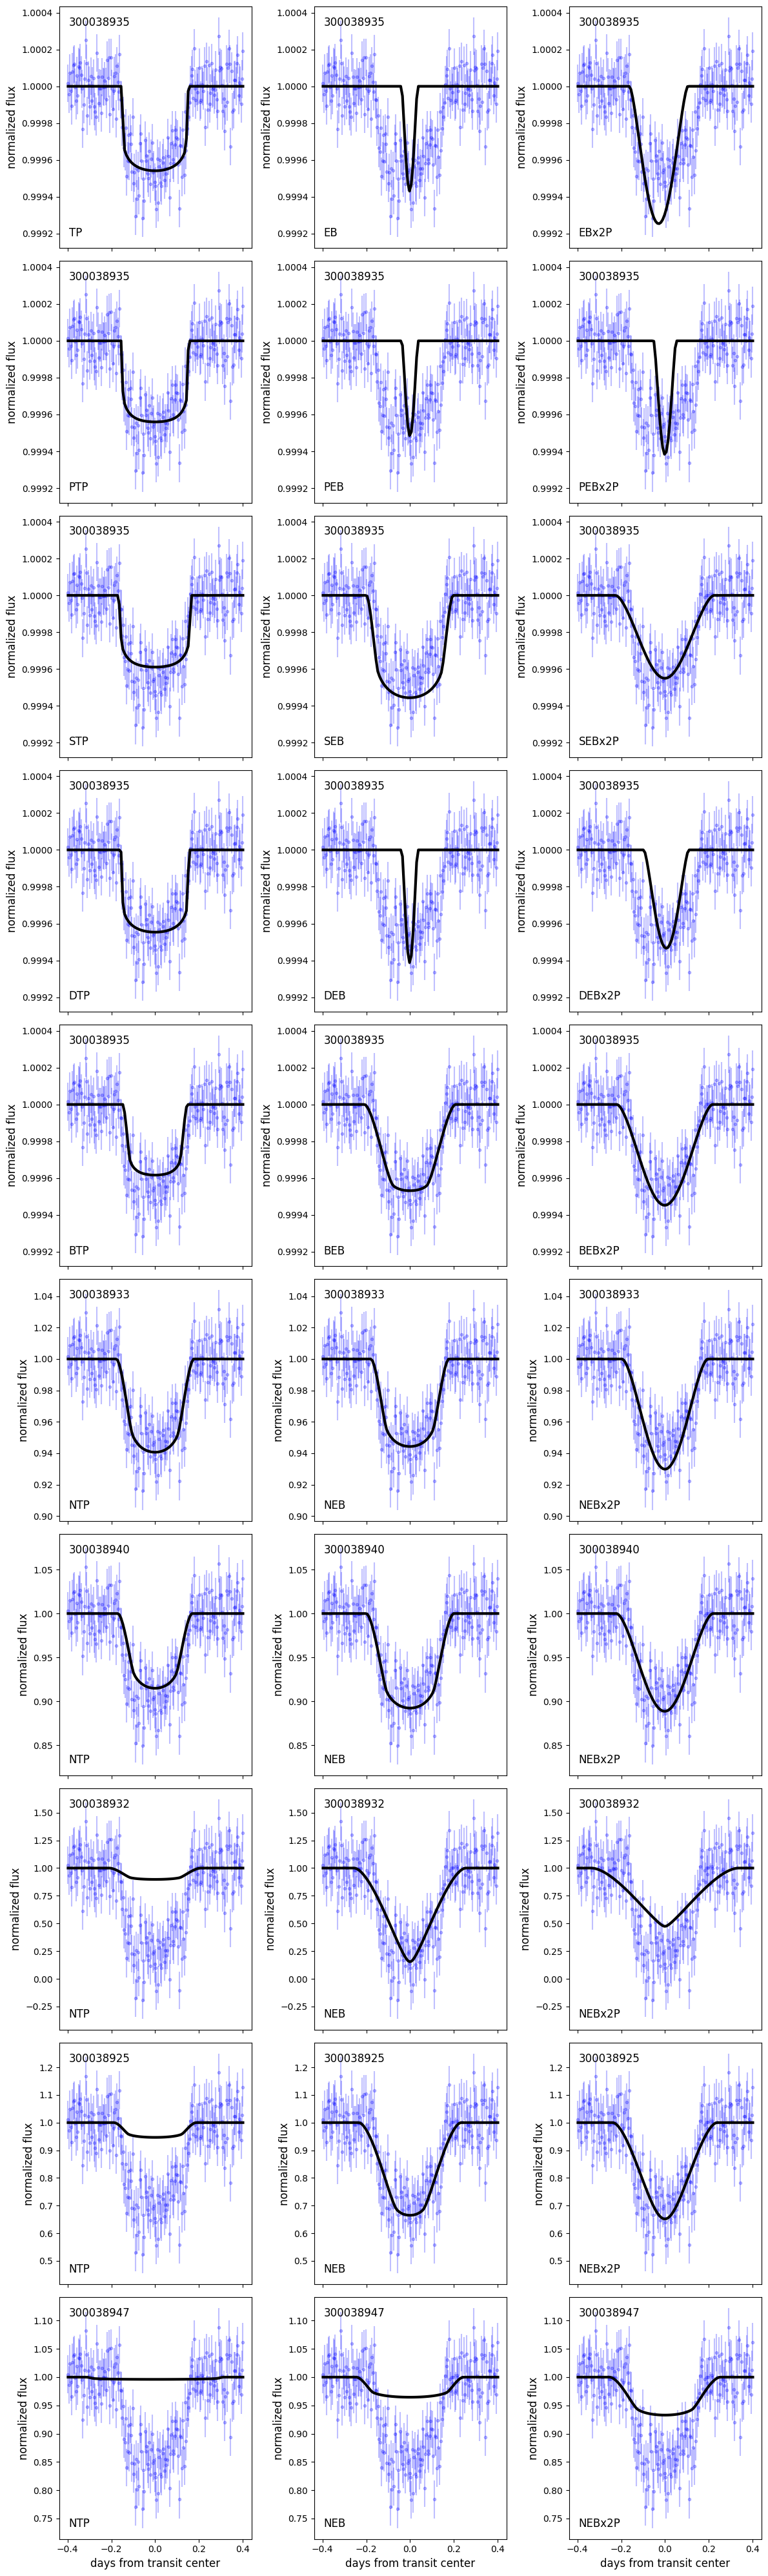

In [58]:
target.plot_fits(time=t_binned,                         # binned time data
                 flux_0=y_binned,                       # binned flux data
                 flux_err_0=np.std(y_binned[:50]),      # standard deviation of (out-of-transit) flux data
                 save=False,                            # whether or not to save the plot
                 fname=None)                            # filename, if saved

### Step 7: Repeat the calculation.

There is intrinsic variability in the results of TRICERAOTPS. In other words, the FPP and NFPP will change from run to run. To be robust, you should run the code (at least 20 times) and quote the mean/median and standard deviation of the results. If they all return very low values for FPP and NFPP, you've almost certainly got a bona fide planet!